# Comparing models predictions 

This compares the output of the `predict_img.sh` script

In [1]:
import sys
sys.path.append('..')
import os
import agronn.classif2 as classif2
import random
import seaborn as sns
import numpy as np
import unidecode
import numpy.ma as ma
import pylab as pl
import skimage
import matplotlib.cm as cm
import skimage.color as skcolor
import sklearn.cross_validation as skcross
import scipy.stats as stats
from osgeo import gdal
from osgeo import ogr
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [2]:
sns.set_style('white')

In [3]:
EXP = 0

saveprefix = 'exp_%d' % EXP

23 classes


<matplotlib.colorbar.Colorbar instance at 0x7f83598fe998>

/home/julien/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


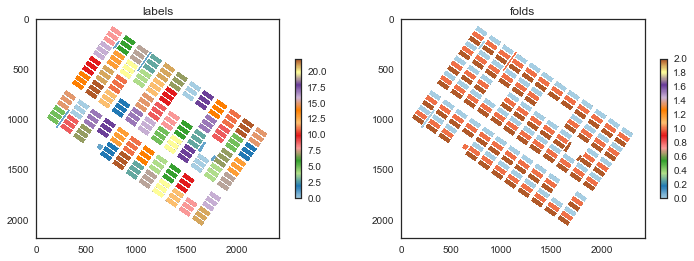

In [4]:
if EXP == 0:
    label_set = 4
else:
    label_set = 6
labels, id2label, folds, _ = classif2.load_labels(label_set)
#labels, id2label, folds, _ = classif2.load_labels(6)
id2label = np.array([unidecode.unidecode(l) for l in id2label])
nclasses = len(id2label)

print len(id2label), 'classes'

pl.figure(figsize=(12, 5))
pl.subplot(121)
pl.title('labels')
pl.imshow(labels, cmap=cm.Paired)
pl.colorbar(shrink=0.5)

pl.subplot(122)
pl.title('folds')
pl.imshow(folds, cmap=cm.Paired)
pl.colorbar(shrink=0.5)

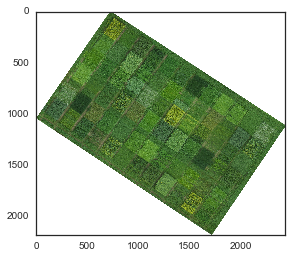

In [5]:
img_rgb = classif2.load_image('2013_10_08', 'rgb')
img_rgb = skimage.img_as_float(img_rgb).astype(np.float32)
# white background
img_rgb[np.all(img_rgb == 0, axis=2), :] = (1, 1, 1)
pl.imshow(img_rgb)

In [6]:
if EXP == 0:
    RESDIR='../../results/rot90_final/labels_4_test_fold_0_rep_0_gpu0_2015_11_16_10_16_06_epochs_60_60_60/'
elif EXP == 1:
    RESDIR='../../results/rot90_final/labels_6_test_fold_0_rep_5_gpu0_2015_11_17_20_21_08_epochs_60_60_60/'

_d = np.load(os.path.join(RESDIR, '_pred_merged_nn.zip', 'pred_img.npz'))
pred_img_mnn = ma.masked_where(_d['pred_mask'], _d['pred_img'])
_d = np.load(os.path.join(RESDIR, '_pred_cnn.zip', 'pred_img.npz'))
pred_img_cnn = ma.masked_where(_d['pred_mask'], _d['pred_img'])
_d = np.load(os.path.join(RESDIR, '_pred_histnn.zip', 'pred_img.npz'))
pred_img_hnn = ma.masked_where(_d['pred_mask'], _d['pred_img'])

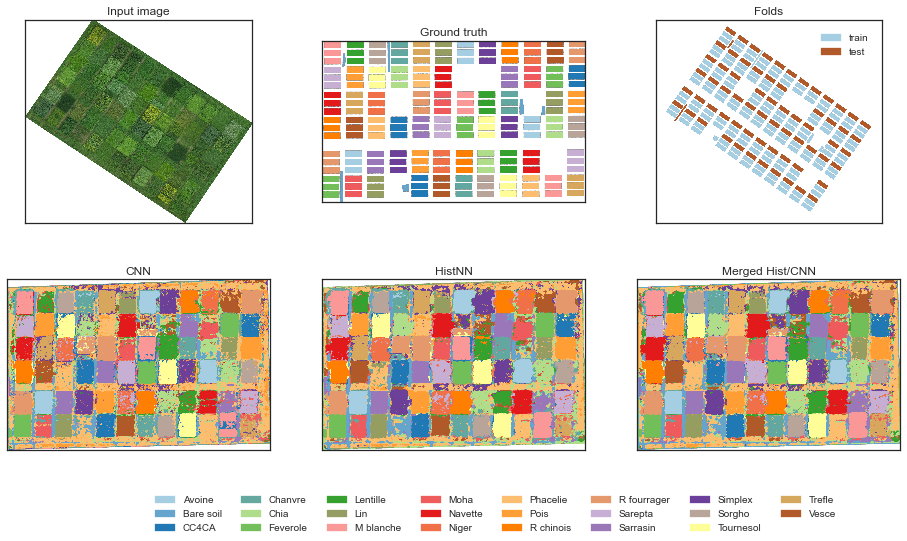

In [7]:
import matplotlib.colors as mplcolors
import skimage.transform as sktransf

def _show_labs(limg, cmap):
    vimg = np.zeros((limg.shape[0], limg.shape[1], 4), dtype=np.float32)
    for lid in xrange(len(id2label)):
        vimg[(limg == lid).filled(False)] = lab_cmap.to_rgba(lid)
        
    def _rot(img, angle=35):
        #return sktransf.rotate(img, angle, cval=0, mode='constant', order=3)
        
        rotated = sktransf.rotate(img, angle, cval=0, mode='constant', order=3)
        # autocrop
        
        if True:
            ii, jj = np.nonzero(rotated[:,:,3])
            mini, maxi = np.min(ii), np.max(ii)
            minj, maxj = np.min(jj), np.max(jj)
            rotated = rotated[mini:maxi, minj:maxj]
        return rotated
    if True:
        vimg = _rot(vimg)
        
    #pl.imshow(limg, cmap=cmap.cmap, norm=cmap.norm)
    pl.imshow(vimg)
    pl.gca().get_xaxis().set_ticks([])
    pl.gca().get_yaxis().set_ticks([])
    
fold_cmap = cm.ScalarMappable(mplcolors.Normalize(vmin=0, vmax=1), cmap=cm.Paired)
# inclusive
lab_cmap = cm.ScalarMappable(mplcolors.Normalize(vmin=0, vmax=22), cmap=cm.Paired)
    
pl.figure(figsize=(16, 8))
pl.subplot(231)
pl.title('Input image')
pl.imshow(img_rgb)
pl.gca().get_xaxis().set_ticks([])
pl.gca().get_yaxis().set_ticks([])

pl.subplot(232)
pl.title('Ground truth')
_show_labs(labels, lab_cmap)
# --- Folds
pl.subplot(233)
pl.title('Folds')
pl.imshow(folds == 0, cmap=fold_cmap.cmap, norm=fold_cmap.norm)
pl.gca().get_xaxis().set_ticks([])
pl.gca().get_yaxis().set_ticks([])

lgd_handles = []
lgd_labels = []
for lid, lname in [(0, 'train'), (1, 'test')]:
    col = fold_cmap.to_rgba(lid)
    artist = pl.Rectangle((0, 0), 1, 1, color=col)
    lgd_handles.append(artist)
    lgd_labels.append(lname)

pl.legend(lgd_handles, lgd_labels, loc='upper right',
          ncol=1, borderaxespad=1, frameon=False)

# -- Predictions
pl.subplot(234)
pl.title('CNN')
_show_labs(pred_img_cnn, lab_cmap)
pl.subplot(235)
pl.title('HistNN')
_show_labs(pred_img_hnn, lab_cmap)
pl.subplot(236)
pl.title('Merged Hist/CNN')
_show_labs(pred_img_mnn, lab_cmap)

# Class cmap
lgd_handles = []
lgd_labels = []
for lid, lname in enumerate(id2label):
    col = lab_cmap.to_rgba(lid)
    artist = pl.Rectangle((0, 0), 1, 1, color=col)
    lgd_handles.append(artist)
    lgd_labels.append(lname)

lgd = pl.figlegend(lgd_handles, lgd_labels, loc='lower center',
             bbox_to_anchor=(0.43, -0.01),
             ncol=8, borderaxespad=1, frameon=False)

pl.savefig('../../latex/figs/%s_classifmaps.pdf' % saveprefix, dpi=200, bbox_inches='tight',
           bbox_extra_artists=(lgd,))


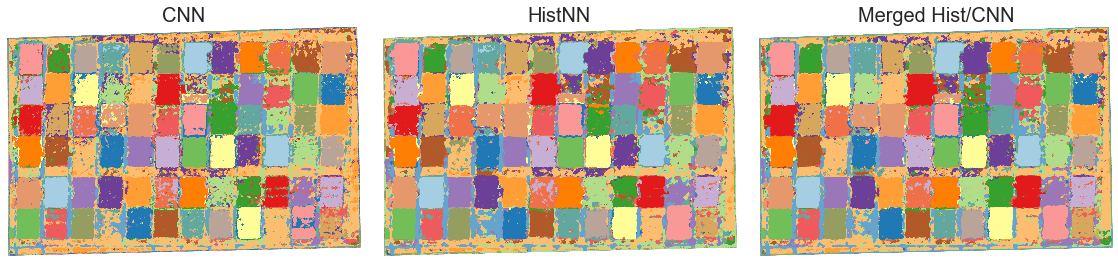

In [13]:
pl.figure(figsize=(16, 5))

#matplotlib.rcParams.update({'font.size': 15})

# -- Predictions
pl.subplot(131)
pl.title('CNN', fontsize=20)
pl.axis('off')
_show_labs(pred_img_cnn, lab_cmap)
pl.subplot(132)
pl.title('HistNN', fontsize=20)
pl.axis('off')
_show_labs(pred_img_hnn, lab_cmap)
pl.subplot(133)
pl.title('Merged Hist/CNN', fontsize=20)
pl.axis('off')
_show_labs(pred_img_mnn, lab_cmap)

pl.tight_layout()

pl.savefig('../../latex/figs/%s_classifmaps_predonly.pdf' % saveprefix, dpi=200, bbox_inches='tight')

# Class cmap
#lgd_handles = []
#lgd_labels = []
#for lid, lname in enumerate(id2label):
#    col = lab_cmap.to_rgba(lid)
#    artist = pl.Rectangle((0, 0), 1, 1, color=col)
#    lgd_handles.append(artist)
#    lgd_labels.append(lname)
#
#lgd = pl.figlegend(lgd_handles, lgd_labels, loc='lower center',
#             bbox_to_anchor=(0.43, 0.02),
#             ncol=8, borderaxespad=1, frameon=False)

#pl.savefig('../../latex/figs/%s_classifmaps_predonly.pdf' % saveprefix, dpi=200, bbox_inches='tight',
#           bbox_extra_artists=(lgd,))


# Quantitative results (for test fold)

In [9]:
import sklearn.metrics as skmetrics

In [10]:
test_idx = folds[~labels.mask] == 0
print test_idx.shape

(1104372,)


In [11]:
y_true = labels[~labels.mask]
cnn_pred = pred_img_cnn[~labels.mask]
hnn_pred = pred_img_hnn[~labels.mask]
mnn_pred = pred_img_mnn[~labels.mask]

print '-- CNN'
print skmetrics.classification_report(y_true[test_idx], cnn_pred[test_idx], labels=np.arange(nclasses),
                                      target_names=id2label)

print '-- HistNN'
print skmetrics.classification_report(y_true[test_idx], hnn_pred[test_idx], labels=np.arange(nclasses),
                                      target_names=id2label)

print '-- Merged'
print skmetrics.classification_report(y_true[test_idx], mnn_pred[test_idx], labels=np.arange(nclasses),
                                      target_names=id2label)

-- CNN
             precision    recall  f1-score   support

     Avoine       0.91      0.99      0.95     16486
  Bare soil       0.78      0.85      0.81      5632
      CC4CA       0.90      0.92      0.91     16486
    Chanvre       0.73      0.86      0.79     16486
       Chia       0.63      0.72      0.67     16487
   Feverole       0.99      0.98      0.99     16483
   Lentille       0.85      0.71      0.78     16485
        Lin       0.96      0.78      0.86     16483
  M blanche       1.00      0.98      0.99     16486
       Moha       0.55      0.40      0.46     16484
    Navette       0.97      0.94      0.95     16486
      Niger       0.90      0.69      0.78     16482
   Phacelie       0.54      0.62      0.58     16484
       Pois       0.82      0.99      0.89     16485
  R chinois       0.94      0.96      0.95     16486
R fourrager       0.98      0.97      0.98     16488
    Sarepta       0.80      0.89      0.84     16486
   Sarrasin       0.94      0.88      

# (normalized by row) confmats

/home/julien/dev/seaborn/seaborn/matrix.py:134: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
/home/julien/dev/seaborn/seaborn/matrix.py:142: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


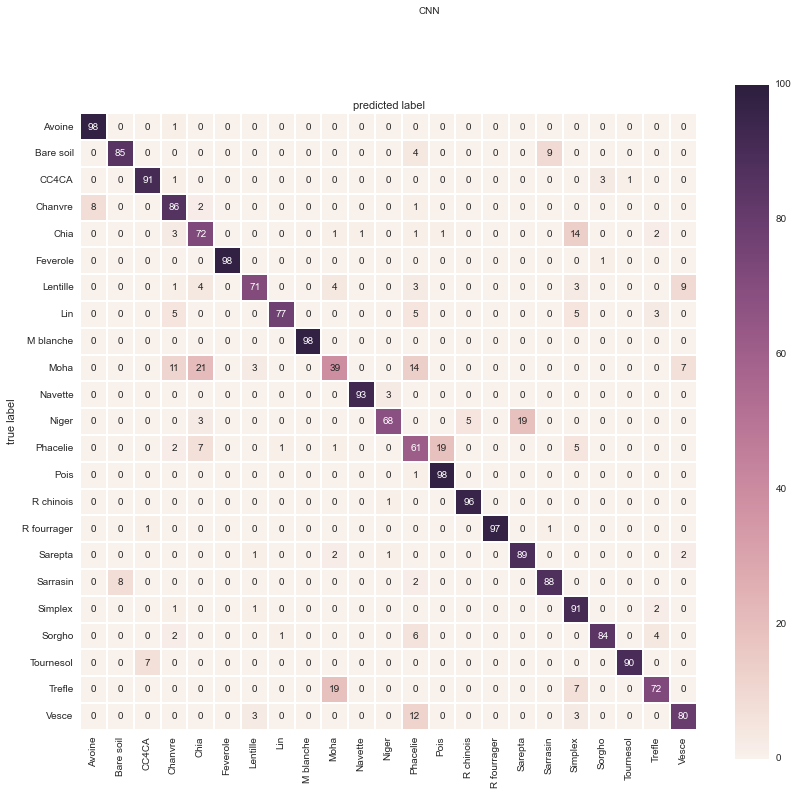

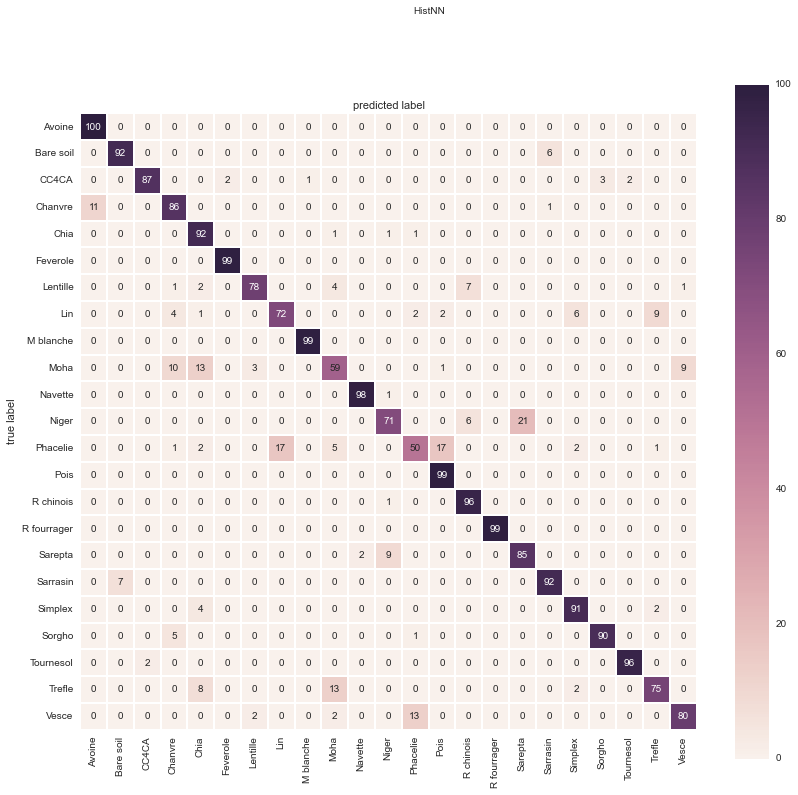

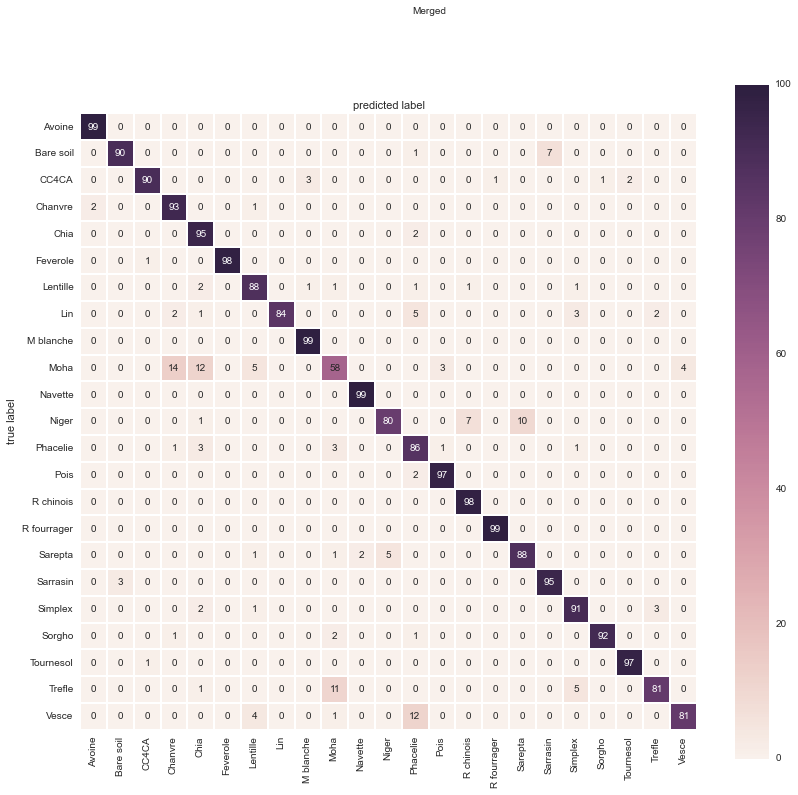

In [12]:
def n_confmat(y_pred):
    cm = skmetrics.confusion_matrix(y_true[test_idx], y_pred, labels=np.arange(nclasses))
    cm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
    return cm
cnn_confmat = n_confmat(cnn_pred[test_idx])
hnn_confmat = n_confmat(hnn_pred[test_idx])
mnn_confmat = n_confmat(mnn_pred[test_idx])

#vmax = max(cnn_confmat.max(), hnn_confmat.max(), mnn_confmat.max())

def plot_confmat_for(confmat, ax=None):
    ax = sns.heatmap((100 * confmat).astype(np.int), annot=True, fmt="d", xticklabels=id2label,
                     square=True, yticklabels=id2label, ax=ax, vmin=0, vmax=100,
                     cbar_kws={'shrink':0.8}, linewidths=1)
    ax.xaxis.set_label_position('top')
    ax.set_xlabel('predicted label')
    ax.set_ylabel('true label')
    pl.tight_layout()


# TODO: Use same vmin, vmax
pl.figure(figsize=(12, 12))
pl.suptitle('CNN')
plot_confmat_for(cnn_confmat)
#pl.savefig('../../latex/figs/classifmap_cnn_confmat.pdf', bbox_inches='tight',
#           bbox_extra_artists=(lgd,))

pl.figure(figsize=(12, 12))
pl.suptitle('HistNN')
plot_confmat_for(hnn_confmat)
#pl.savefig('../../latex/figs/classifmap_hnn_confmat.pdf', bbox_inches='tight',
#           bbox_extra_artists=(lgd,))

pl.figure(figsize=(12, 12))
pl.suptitle('Merged')
plot_confmat_for(mnn_confmat)
#pl.savefig('../../latex/figs/classifmap_mnn_confmat.pdf', bbox_inches='tight',
#           bbox_extra_artists=(lgd,))
